# Artificial Neural Networks and Deep Learning

---

## Lecture 3a: Convolutional Neural Networks

<img src="https://drive.google.com/uc?export=view&id=1ffjpWwLSS5XwEW2GVW0D_hpwgSw1Mf3g" width="500"/>

### 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Lecture 3

### ⚙️ Import Libraries

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.0


## ⏳ Load Data

In [2]:
# Load CIFAR10 dataset and split into training-validation and test sets
(X_train_val, y_train_val), (X_test, y_test) = tfk.datasets.cifar10.load_data()

# Define a mapping of labels to their corresponding digit names
labels = {0:'Airplane', 1:'Automobile', 2:'Bird', 3:'Cat', 4:'Deer', 5:'Dog', 6:'Frog', 7:'Horse', 8:'Ship', 9:'Truck'}

# Save unique labels
unique_labels = list(labels.values())

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


## 🔎 Inspect Data

In [3]:
# Print the shapes of the loaded datasets
print("Training-Validation Data Shape:", X_train_val.shape)
print("Training-Validation Label Shape:", y_train_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training-Validation Data Shape: (50000, 32, 32, 3)
Training-Validation Label Shape: (50000, 1)
Test Data Shape: (10000, 32, 32, 3)
Test Label Shape: (10000, 1)


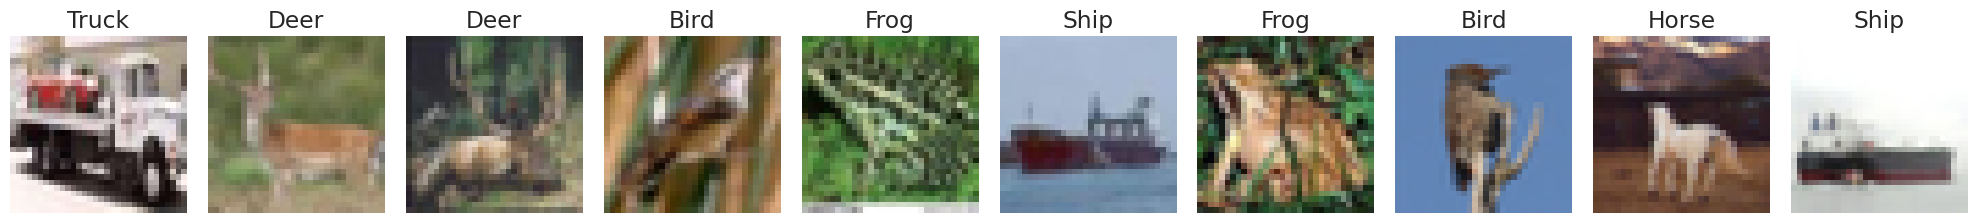

In [4]:
# Display a sample of images from the training-validation dataset
num_img = 10
random_indices = random.sample(range(len(X_train_val)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X_train_val[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{labels[y_train_val[idx][0]]}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [5]:
# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y_train_val, columns=['digit'])['digit'].value_counts())

Counting occurrences of target classes:
digit
6    5000
9    5000
4    5000
1    5000
2    5000
7    5000
8    5000
3    5000
5    5000
0    5000
Name: count, dtype: int64


## 🔄 Process Data

In [6]:
# Normalize data to the range [0, 1]
X_train_val = (X_train_val / 255).astype('float32')
X_test = (X_test / 255).astype('float32')

# Convert labels to categorical format using one-hot encoding
y_train_val = tfk.utils.to_categorical(y_train_val)
y_test = tfk.utils.to_categorical(y_test)

In [7]:
# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1, stratify=y_train_val)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (45000, 32, 32, 3)
Training Label Shape: (45000, 10)
Validation Data Shape: (5000, 32, 32, 3)
Validation Label Shape: (5000, 10)


In [8]:
# Compare categorical label and "default" label representation
# Display the categorical label
print('Categorical label:', y_train[0])
# Display the equivalent numeric label
print('"Default" label:', np.argmax(y_train[0]))

Categorical label: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
"Default" label: 8


## 👁️ Convolutional Neural Networks

<img src="https://miro.medium.com/v2/format:webp/1*oB3S5yHHhvougJkPXuc8og.gif" width="500">

#### **What is a "Convolution"?**

A convolution is a mathematical operation on two objects, an input information and a kernel, to produce an outcome that expresses how the shape of one is modified by the other.

<img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*LkBTMMY49OTF-I84yESMjQ.png" width="500">

**Kernel (or Filter)**

Since the RGB and greyscale channels of an image are in 2D dimensions, the kernel of a convolution that operates in the image domain has the form of a 2D matrix.

<img src="https://courses.cs.washington.edu/courses/cse446/21au/sections/08/correlation.png" width="400">

The output of a convolution operation is called a feature map, while the convolution kernel is often referred to as the filter, channel or feature detector of a convolution.

<img src="https://miro.medium.com/v2/resize:fit:750/format:webp/0*0Mukvf3OWXtmFJp3" width="350">

**Convolutional Layer**

A "Convolutional Layer" is a set of trainable kernels that act as a feature extractor, given a set of input data, a problem to be solved, and an optimisation strategy.

<img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*AS6aFoW8sq7kt5vAiP_5bA.png" width="500">

The number of kernels, called filters in TensorFlow, is not the only descriptive parameter of a convolutional layer. Among the most important are the strides and the padding.

**Strides**

The strides are the number of cells that the filter moves at each iteration. The usefulness of having strides greater than one is to prevent the output feature map from being too similar to the input, while at the same time reducing its size.

**Padding**

Padding is the size of the frame - typically consisting of zeros - to surround the input. The utility of such a frame is to change the size of the output feature map to control its size. It is typically used in conjunction with steps to one to make the input and feature map the same size.

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*Tq_lyA2uRy4BTBpYlbKTTQ.gif" width="650">

Whereas for dense or fully-connected neural networks the number of parameters between two layers is given by the product of the number of neurons in the first layer and the number of neurons in the second layer plus one for bias, the parameters of a convolutional layer are a function of filter size, strides and padding.

Given $C_{in}$ as the number of input channels, $f_h$ and $f_w$ as the filter dimensions, height and width respectively, and $C_{out}$ as the number of output channels, the number of parameters of a convolutional layer can be calculated as follows:

**Parameters** = $(f_h \times f_w \times C_{in} + 1) \times C_{out}$.

Finally, with a padding value of $p$ and a step size equal to $s$, the output shape of a convolutional layer can be computed as:

**Output Shape** = $(\lfloor\frac{H_{in} + 2p - f_h}{s}+1\rfloor, \lfloor\frac{W_{in} + 2p - f_w}{s}+1\rfloor, C_{out})$

where $H_{in}$ and $W_{in}$ represent the height and width of the input respectively.

**Pooling Layer**

The pooling operation built into the pooling layer is an aparametric transformation whose purpose is to reduce the spatial dimensionality of the input tensor - in other words, to reduce the height and width of the feature maps - typically through maximum or average operations. Again, there are stride and kernel size parameters, but by convention the value 2 is used in both cases.

<img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*-3-9b0tAakAsdozzhNlEww.png" width="600">

**Flatten Layer**

The purpose of the flattening operation is to 'unwind' the filters computed by the convolution and pooling layers so that they can be processed by one or more fully connected layers, thus enabling prediction in the context of classification and regression.

<img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*IWUxuBpqn2VuV-7Ubr01ng.png" width="500">

## 🧮 Define Network Parameters

In [9]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (32, 32, 3)
Output Shape: 10


In [10]:
# Number of training epochs
epochs = 1000

# Batch size for training
batch_size = 128

# Learning rate: step size for updating the model's weights
learning_rate = 0.001

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rare:", learning_rate)

Epochs: 1000
Batch Size: 128
Learning Rare: 0.001


## 🛠️ Build the Model

<img src="https://www.researchgate.net/publication/345788674/figure/fig1/AS:957248478117889@1605237230738/Overview-and-details-of-a-convolutional-neural-network-CNN-architecture-for-image_W640.jpg" width="400">

In [13]:
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate,
    seed=seed
):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    inputs = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv1')(inputs) # Reco : kernel between 3 and 5
    x = tfkl.Activation('relu', name='act1')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp1')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.Activation('relu', name='act2')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp2')(x)

    x = tfkl.Flatten(name='flatten')(x)

    x = tfkl.Dense(units=output_shape, name='dense')(x)
    outputs = tfkl.Activation('softmax', name='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=inputs, outputs=outputs, name='CNN')

    # Compile the model
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the model
    return model

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 32, 32, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv2D)                      │ (None, 32, 32, 32)           │           896 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act1 (Activation)                   │ (None, 32, 32, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp1 (MaxPooling2D)                  │ (None, 16, 16, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2 (Conv2D)                      │ (None, 16, 16, 64)           │        18,496 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act2 (Activation)                   │ (None, 16, 16, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp2 (MaxPooling2D)                  │ (None, 8, 8, 64)             │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten (Flatten)                   │ (None, 4096)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 10)                   │        40,970 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ softmax (Activation)                │ (None, 10)                   │             0 │    -    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 60,362 (235.79 KB)

 Trainable params: 60,362 (235.79 KB)

 Non-trainable params: 0 (0.00 B)

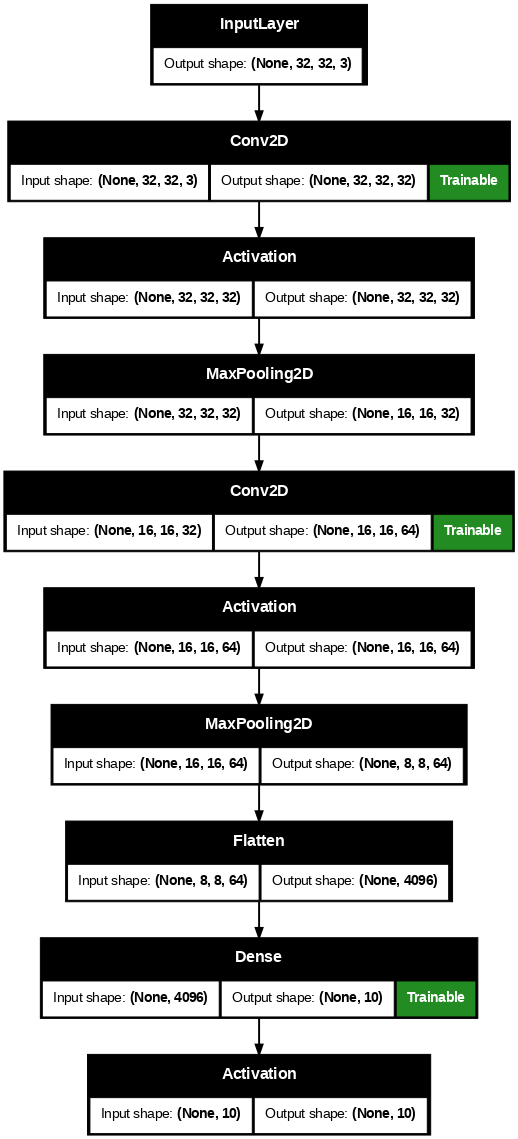

In [14]:
# Build the model with specified input and output shapes
model = build_model()

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

## 🧠 Train the Model

In [15]:
# Define the patience value for early stopping
patience = 20

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [17]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'CIFAR10_CNN_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/1000
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8078 - loss: 0.5610 - val_accuracy: 0.7034 - val_loss: 0.9280
Epoch 2/1000
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8142 - loss: 0.5453 - val_accuracy: 0.7012 - val_loss: 0.9406
Epoch 3/1000
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8192 - loss: 0.5305 - val_accuracy: 0.6990 - val_loss: 0.9572
Epoch 4/1000
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8246 - loss: 0.5154 - val_accuracy: 0.6964 - val_loss: 0.9760
Epoch 5/1000
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8306 - loss: 0.5014 - val_accuracy: 0.6946 - val_loss: 0.9934
Epoch 6/1000
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8342 - loss: 0.4884 - val_accuracy: 0.6874 - val_loss: 1.0140
Epoch 7/1000
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8388 - loss: 0.4776 - val_accuracy: 0.6864 - val_loss: 1.0282
Epoch 8/1000
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8414 - loss: 0.4679 - 

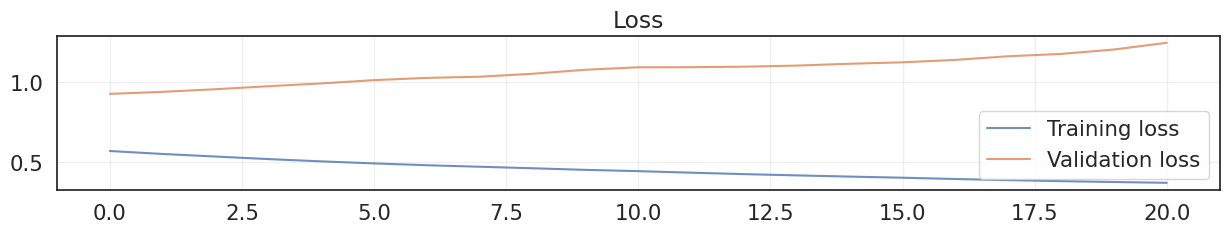

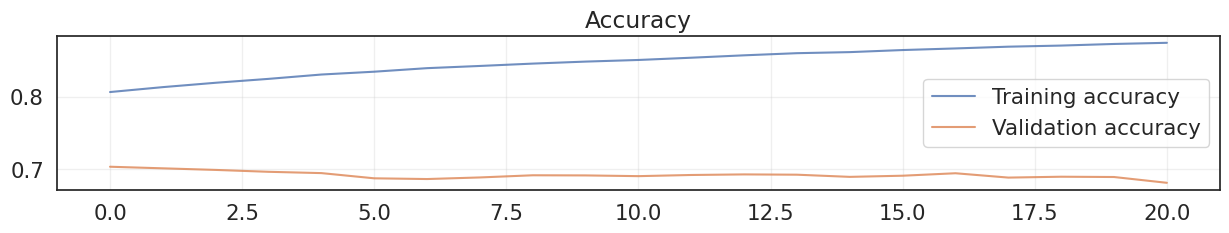

In [21]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

## 🕹️ Use the Model - Make Inference

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 32, 32, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv2D)                      │ (None, 32, 32, 32)           │           896 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act1 (Activation)                   │ (None, 32, 32, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp1 (MaxPooling2D)                  │ (None, 16, 16, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2 (Conv2D)                      │ (None, 16, 16, 64)           │        18,496 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act2 (Activation)                   │ (None, 16, 16, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp2 (MaxPooling2D)                  │ (None, 8, 8, 64)             │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten (Flatten)                   │ (None, 4096)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 10)                   │        40,970 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ softmax (Activation)                │ (None, 10)                   │             0 │    -    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 181,088 (707.38 KB)

 Trainable params: 60,362 (235.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 120,726 (471.59 KB)

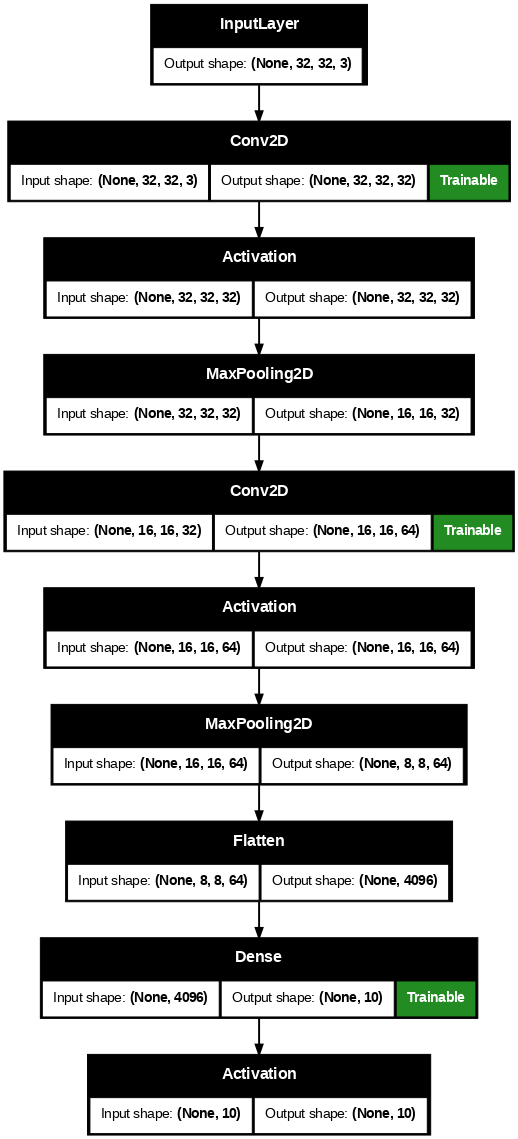

In [22]:
# Load the saved model
model = tfk.models.load_model('CIFAR10_CNN_70.34.keras')

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

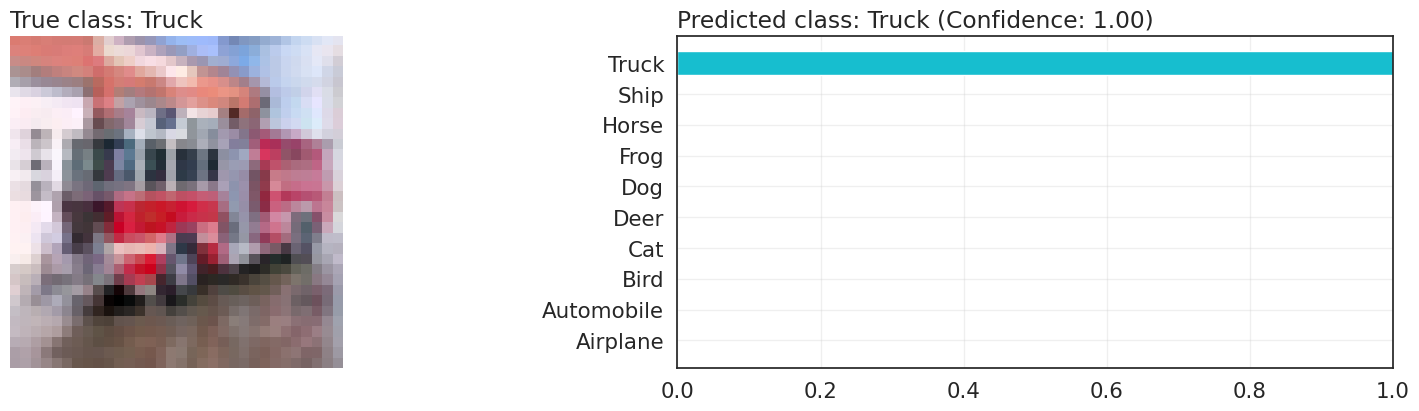

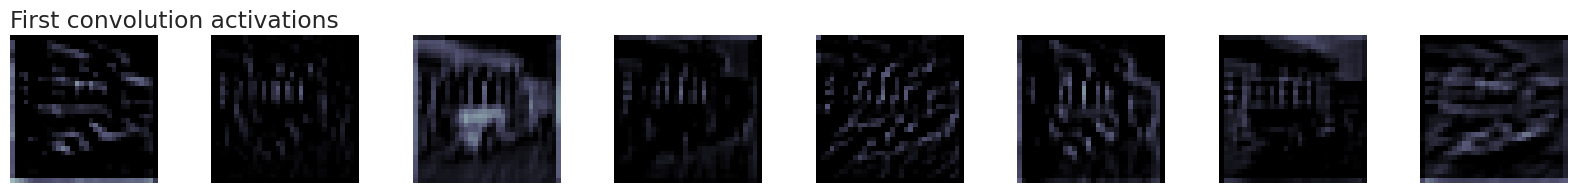

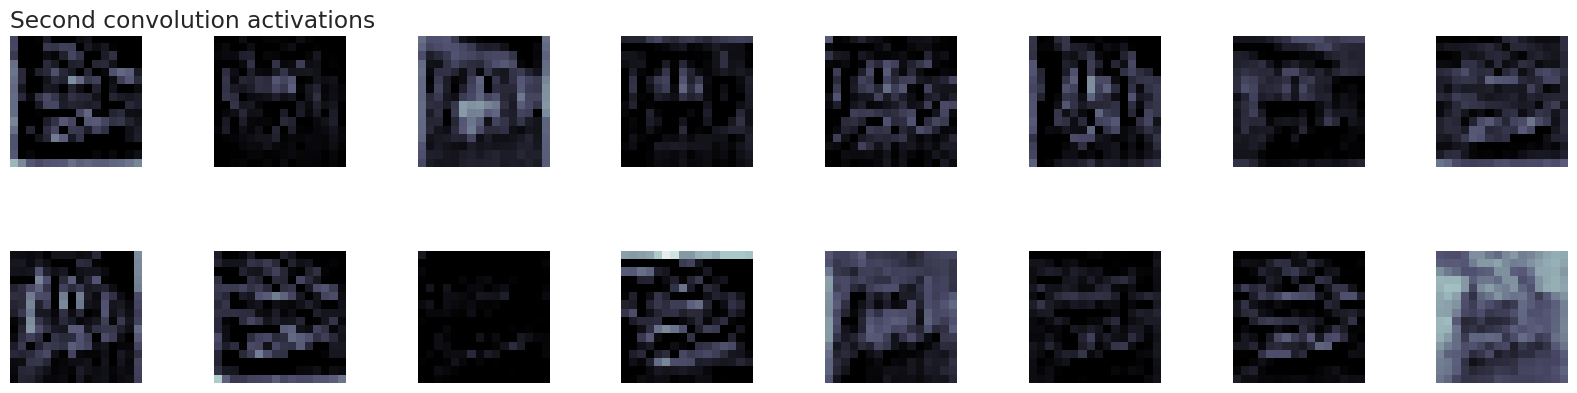

In [23]:
def extract_activations(model, X, num_images):

    # Identify the first convolutional layer
    first_conv_index = None
    for i, layer in enumerate(model.layers):
        if isinstance(layer, tfk.layers.Conv2D):
            first_conv_index = i
            break

    if first_conv_index is None:
        raise ValueError("The model does not contain a 2D convolution")

    # Extract activations from the first convolutional layer
    first_conv = tfk.Sequential(model.layers[:first_conv_index + 1])
    first_activations = first_conv(X[:num_images])

    # Identify the first pooling layer after the first convolution
    pooling_index = None
    for i, layer in enumerate(model.layers[first_conv_index + 1:], start=first_conv_index + 1):
        if isinstance(layer, (tfk.layers.MaxPooling2D, tfk.layers.AveragePooling2D)):
            pooling_index = i
            break

    if pooling_index is None:
        raise ValueError("The model does not contain a 2D pooling operation after the first convolution")

    # Extract activations from the first convolution and the first pooling layer
    second_conv = tfk.Sequential(model.layers[:pooling_index + 1])
    second_activations = second_conv(X[:num_images])

    return first_activations, second_activations

def find_last_conv_layer(model):

    # Identify the last convolutional layer in the model
    for layer in reversed(model.layers):
        if isinstance(layer, tfk.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in the model.")

def visualize(model, X, y, unique_labels, num_images=50, display_activations=True):

    # Extract activations from the model
    first_activations, second_activations = extract_activations(model, X, num_images)

    # Select a random image for prediction and visualisation
    image = np.random.randint(0, num_images)
    predictions = model.predict(np.expand_dims(X[image], axis=0), verbose=0)
    class_int = np.argmax(predictions[0])
    class_str = unique_labels[class_int]

    # Create figure layout for displaying the image and predictions
    fig = plt.figure(constrained_layout=True, figsize=(16, 4))
    gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1.5, 1.5], wspace=0)

    # Display the selected image with the true class
    ax1 = fig.add_subplot(gs[0])
    ax1.set_title(f"True class: {unique_labels[np.argmax(y[image])]}", loc='left')
    if X[image].shape[-1] == 1:
        ax1.imshow(np.squeeze(X[image]), cmap='bone', vmin=0., vmax=1.)
    else:
        ax1.imshow(np.squeeze(X[image]), vmin=0., vmax=1.)
    ax1.axis('off')

    # Display the prediction bar
    ax2 = fig.add_subplot(gs[1])
    ax2.barh(unique_labels, np.squeeze(predictions, axis=0), color=plt.get_cmap('tab10').colors)
    ax2.set_title(f"Predicted class: {class_str} (Confidence: {max(np.squeeze(predictions, axis=0)):.2f})", loc='left')
    ax2.grid(alpha=0.3)
    ax2.set_xlim(0.0, 1.0)

    plt.show()

    # Display activations if required
    if display_activations:
        # Visualise the activations from the first convolutional layer
        fig, axes = plt.subplots(1, 8, figsize=(16, 14))
        for i in range(8):
            ax = axes[i]
            ax.imshow(first_activations[image, :, :, i], cmap='bone', vmin=0., vmax=1.)
            ax.axis('off')
            if i == 0:
                ax.set_title('First convolution activations', loc='left')
        plt.tight_layout()
        plt.show()

        # Visualise the activations from the first pooling layer
        fig, axes = plt.subplots(2, 8, figsize=(16, 5))
        for i in range(16):
            ax = axes[i // 8, i % 8]
            ax.imshow(second_activations[image, :, :, i], cmap='bone', vmin=0., vmax=1.)
            ax.axis('off')
            if i == 0:
                ax.set_title('Second convolution activations', loc='left')
        plt.tight_layout()
        plt.show()

# Example usage
visualize(model, X_test, y_test, unique_labels, display_activations=True)

In [24]:
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (10000, 10)


Accuracy score over the test set: 0.6978
Precision score over the test set: 0.6999
Recall score over the test set: 0.6978
F1 score over the test set: 0.6946


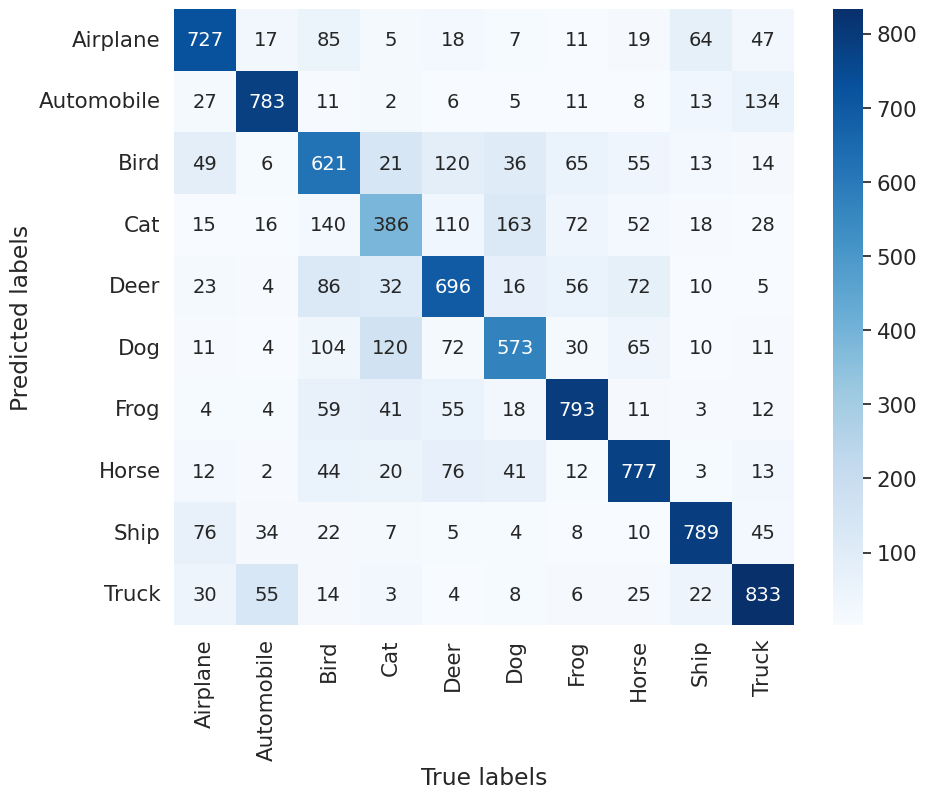

In [25]:
# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()